In [1]:
import numpy as np
import torch
print(torch.__version__)

from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

2.0.1+cu118


In [3]:
from utils import eval_model, train, smooth, save_model, load_model, model_params, eval_plots, set_random_seed, eval_model_conf
from dataset_utils import extract_frames, KTH_dataset

In [4]:
set_random_seed(420)

In [5]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

import os
import shutil

In [6]:
# choose device to be used depending on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### download dataset and unzip

use preloaded from google drive

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!rm -r KTH

In [9]:
%%shell
mkdir KTH
mkdir KTH/data
mkdir KTH/data/videos

unzip /content/gdrive/MyDrive/KTH/videos/boxing.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/handclapping.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/handwaving.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/jogging.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/running.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/walking.zip -d KTH/data/videos

wget -O sequences_list.txt http://www.csc.kth.se/cvap/actions/00sequences.txt


Archive:  /content/gdrive/MyDrive/KTH/videos/boxing.zip
  inflating: KTH/data/videos/person01_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/

### directly download and unzip

In [ ]:
"""
%%shell
mkdir KTH
mkdir KTH/data
mkdir KTH/data/videos

wget -O KTH/data/videos/boxing.zip http://www.csc.kth.se/cvap/actions/boxing.zip
wget -O KTH/data/videos/handclapping.zip http://www.csc.kth.se/cvap/actions/handclapping.zip
wget -O KTH/data/videos/handwaving.zip http://www.csc.kth.se/cvap/actions/handwaving.zip
wget -O KTH/data/videos/jogging.zip http://www.csc.kth.se/cvap/actions/jogging.zip
wget -O KTH/data/videos/running.zip http://www.csc.kth.se/cvap/actions/running.zip
wget -O KTH/data/videos/walking.zip http://www.csc.kth.se/cvap/actions/walking.zip

unzip KTH/data/videos/boxing.zip -d KTH/data/videos
unzip KTH/data/videos/handclapping.zip -d KTH/data/videos
unzip KTH/data/videos/handwaving.zip -d KTH/data/videos
unzip KTH/data/videos/jogging.zip -d KTH/data/videos
unzip KTH/data/videos/running.zip -d KTH/data/videos
unzip KTH/data/videos/walking.zip -d KTH/data/videos

rm KTH/data/videos/*.zip
"""

'\n%%shell\nmkdir KTH\nmkdir KTH/data\nmkdir KTH/data/videos\n\nwget -O KTH/data/videos/boxing.zip http://www.csc.kth.se/cvap/actions/boxing.zip\nwget -O KTH/data/videos/handclapping.zip http://www.csc.kth.se/cvap/actions/handclapping.zip\nwget -O KTH/data/videos/handwaving.zip http://www.csc.kth.se/cvap/actions/handwaving.zip\nwget -O KTH/data/videos/jogging.zip http://www.csc.kth.se/cvap/actions/jogging.zip\nwget -O KTH/data/videos/running.zip http://www.csc.kth.se/cvap/actions/running.zip\nwget -O KTH/data/videos/walking.zip http://www.csc.kth.se/cvap/actions/walking.zip\n\nunzip KTH/data/videos/boxing.zip -d KTH/data/videos\nunzip KTH/data/videos/handclapping.zip -d KTH/data/videos\nunzip KTH/data/videos/handwaving.zip -d KTH/data/videos\nunzip KTH/data/videos/jogging.zip -d KTH/data/videos\nunzip KTH/data/videos/running.zip -d KTH/data/videos\nunzip KTH/data/videos/walking.zip -d KTH/data/videos\n\nrm KTH/data/videos/*.zip\n'

In [10]:
extract_frames('KTH')

Completed till video :  50
Completed till video :  100
Completed till video :  150
Completed till video :  200
Completed till video :  250
Completed till video :  300
Completed till video :  350
Completed till video :  400
Completed till video :  450
Completed till video :  500
Completed till video :  550
[MESSAGE]	Frames extracted from all videos
[ERROR]:  KTH/data/VALIDATION/person01_boxing_d4_frame_246_370
Completed till video :  50
Completed till video :  100
Completed till video :  150
Completed till video :  200
Completed till video :  250
-----------------------------------------------------------
[ERROR MESSAGE]: 
limits :  ['*missing*']
seq_path :  KTH/data/TRAIN/person13_handclapping_d2_frame_401_523
-----------------------------------------------------------
Completed till video :  300
Completed till video :  350
Completed till video :  400
Completed till video :  450
Completed till video :  500
Completed till video :  550
Completed till video :  600
[ALERT]		Total error cou

### code for 3d cnn

In [11]:
import torch.nn as nn

# definition of 3D cnn model
class cnn3DModel(nn.Module):
    """
    input_dims = (n_frames, n_channels, width, height)
    """
    def __init__(self, input_dims, output_features):
        super().__init__()

        self.input_dims = input_dims
        self.output_features = output_features

        self.cnn = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=16, kernel_size = (5,5,5), stride=(1,1,1), padding = (1,2,2)),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2), stride=(2,2,2)),
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size = (3,3,3), stride=(1,1,1), padding = (0,1,1)),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2), stride=(2,2,2)),
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size = (3,3,3), stride=(1,1,1), padding = (0,1,1)),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2), stride=(2,2,2)),
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size = (1,3,3), stride=(1,1,1), padding = (0,1,1)),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2), stride=(2,2,2)),
        )
        n_out_features = int(128* (self.input_dims[2]/16) * (self.input_dims[3]/16))
        
        # classifier
        self.classifier = nn.Sequential(
          nn.Linear(in_features=n_out_features, out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128, out_features=self.output_features),
          )
        
        return
    
    def forward(self, x):
        b_size, n_frames, n_channels, n_rows, n_cols = x.shape
        x_t = x.transpose(1,2) # transpose to be able to use conv3d and maxpool 3d correctly
        out = self.cnn(x_t)
        out = out.view(b_size, -1)
        out = self.classifier(out)

        return out
    

## train models and test them

In [16]:
train_transforms = transforms.Compose([
               transforms.RandomHorizontalFlip(p=0.5),
               transforms.RandomRotation(degrees=5),
               transforms.Resize((64, 64), antialias=True),
               ])

test_transforms = transforms.Compose([
               transforms.Resize((64, 64), antialias=True),
               ])

n_frames = 30


train_dataset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'TRAIN', instance_len = n_frames)
val_dataset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'VALIDATION', instance_len = n_frames)

train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])  # use validation set to train too, as we do not use it here in another way

test_dataset = KTH_dataset('/content/KTH/data',  transforms = test_transforms, mode = 'TEST', instance_len = n_frames)


print(f"Train samples: {len(train_dataset)}")
#print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 4219
Test samples: 2248


In [23]:
BATCH_SIZE = 32
SHUFFLE_TRAIN = True
NUM_EPOCHS = 14
LR = 3e-4
EVAL_FREQ = 1
SAVE_FREQ = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## test our own implementation

In [24]:
cnn_model = cnn3DModel(input_dims = (30,3,64,64), output_features = 6)
cnn_model.to(device)

cnn3DModel(
  (cnn): Sequential(
    (0): Conv3d(3, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (7): ReLU()
    (8): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (10): ReLU()
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=6, bias=

In [25]:
print(f"The model has {model_params(cnn_model)} parameters.")

The model has 412134 parameters.


> This model has more trainable parameters compared to our convLSTM (here 412134 compared to 323606 for our cLSTM). This is 3/4 of the current model, but not a huge difference. (about same order of magnitude)

In [26]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer0 = torch.optim.Adam(cnn_model.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every X epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer0, step_size=12, gamma=0.2)

In [27]:
import time
start_time = time.time()
stats0, model0 = train(cnn_model, NUM_EPOCHS, train_loader, None, val_loader, optimizer0, criterion, EVAL_FREQ, SAVE_FREQ, '/content', device, scheduler, twriter = None, loadpath = None, stats = None)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch -1: valid_loss 1.80148 valid_acc 10.99 | lr 0.0003


100%|██████████| 132/132 [03:00<00:00,  1.37s/it]


Epoch 1: train_loss 1.64009 | valid_loss 1.28884 valid_acc 34.56| lr 0.0003


100%|██████████| 132/132 [03:00<00:00,  1.37s/it]


Epoch 2: train_loss 1.10320 | valid_loss 0.97610 valid_acc 50.53| lr 0.0003


100%|██████████| 132/132 [03:01<00:00,  1.37s/it]


Epoch 3: train_loss 0.87781 | valid_loss 0.89520 valid_acc 55.78| lr 0.0003


100%|██████████| 132/132 [03:01<00:00,  1.37s/it]


Epoch 4: train_loss 0.68186 | valid_loss 0.79620 valid_acc 62.54| lr 0.0003


100%|██████████| 132/132 [02:54<00:00,  1.32s/it]


Epoch 5: train_loss 0.52726 | valid_loss 0.71475 valid_acc 67.04| lr 0.0003


100%|██████████| 132/132 [02:56<00:00,  1.34s/it]


Epoch 6: train_loss 0.42629 | valid_loss 0.63130 valid_acc 74.60| lr 0.0003


100%|██████████| 132/132 [02:54<00:00,  1.32s/it]


Epoch 7: train_loss 0.38487 | valid_loss 0.63192 valid_acc 71.31| lr 0.0003


100%|██████████| 132/132 [02:55<00:00,  1.33s/it]


Epoch 8: train_loss 0.31103 | valid_loss 0.55047 valid_acc 77.62| lr 0.0003


100%|██████████| 132/132 [02:51<00:00,  1.30s/it]


Epoch 9: train_loss 0.28938 | valid_loss 0.49086 valid_acc 80.65| lr 0.0003


100%|██████████| 132/132 [02:58<00:00,  1.35s/it]


Epoch 10: train_loss 0.25385 | valid_loss 0.53292 valid_acc 79.09| lr 0.0003


100%|██████████| 132/132 [02:56<00:00,  1.34s/it]


Epoch 11: train_loss 0.21705 | valid_loss 0.54758 valid_acc 79.23| lr 0.0003


100%|██████████| 132/132 [02:52<00:00,  1.31s/it]


Epoch 12: train_loss 0.22797 | valid_loss 0.52029 valid_acc 79.76| lr 0.0003


100%|██████████| 132/132 [02:57<00:00,  1.34s/it]


Epoch 13: train_loss 0.15755 | valid_loss 0.48441 valid_acc 81.85| lr 5.9999999999999995e-05


100%|██████████| 132/132 [02:58<00:00,  1.35s/it]


Epoch 14: train_loss 0.13967 | valid_loss 0.49320 valid_acc 82.25| lr 5.9999999999999995e-05
--- 3312.2805869579315 seconds ---


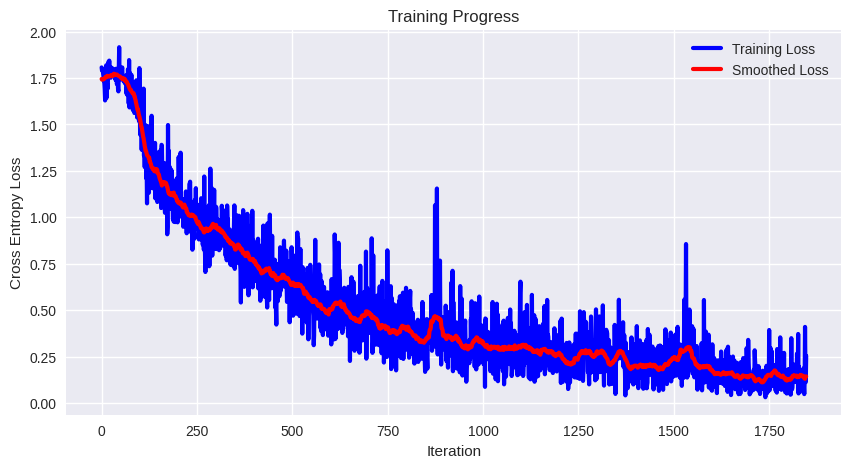

In [28]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

smooth_loss = smooth(stats0["per_batch_loss"], 31)
ax.plot(stats0["per_batch_loss"], c="blue", label="Training Loss", linewidth=3)#, alpha=0.5)
ax.plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax.legend(loc="best")
ax.set_xlabel("Iteration")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Training Progress")

plt.show()

Classification accuracy: 82.25%


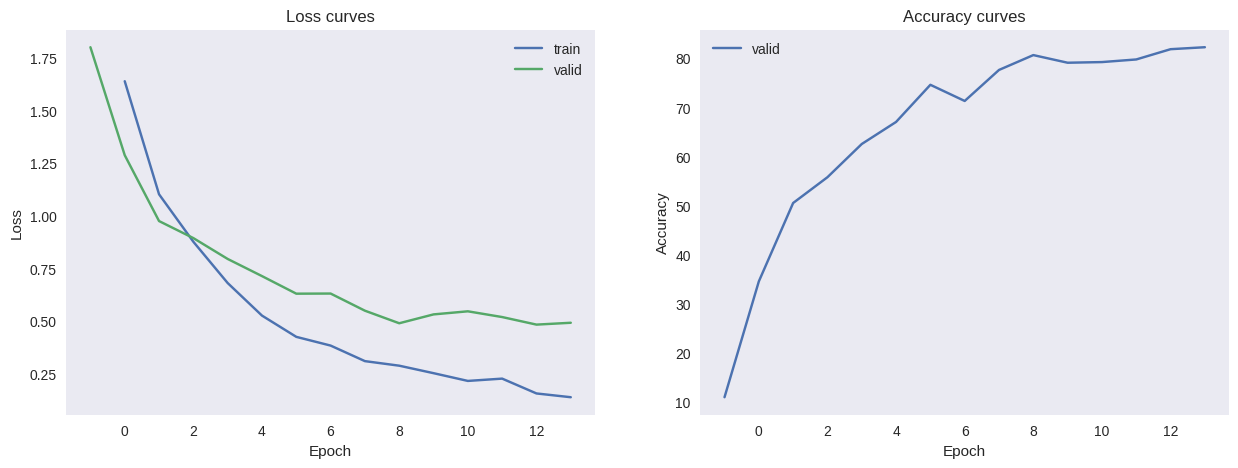

In [29]:
eval_plots(model0, val_loader, criterion, device, stats0)

> The loss and accuracy curves for the 3dCNN look pretty similar to the curve of the convLSTM. However here the loss goes slightly lower and the accuracy goes slightly higher.

> The accuracy here is higher with 82.25% compared to 77.09%. This might be, because of the higher number of parameters.

0:boxing, 1:handclapping, 2:handwaving, 3:jogging, 4:running, 5:walking
Test accuracy: 82.25%


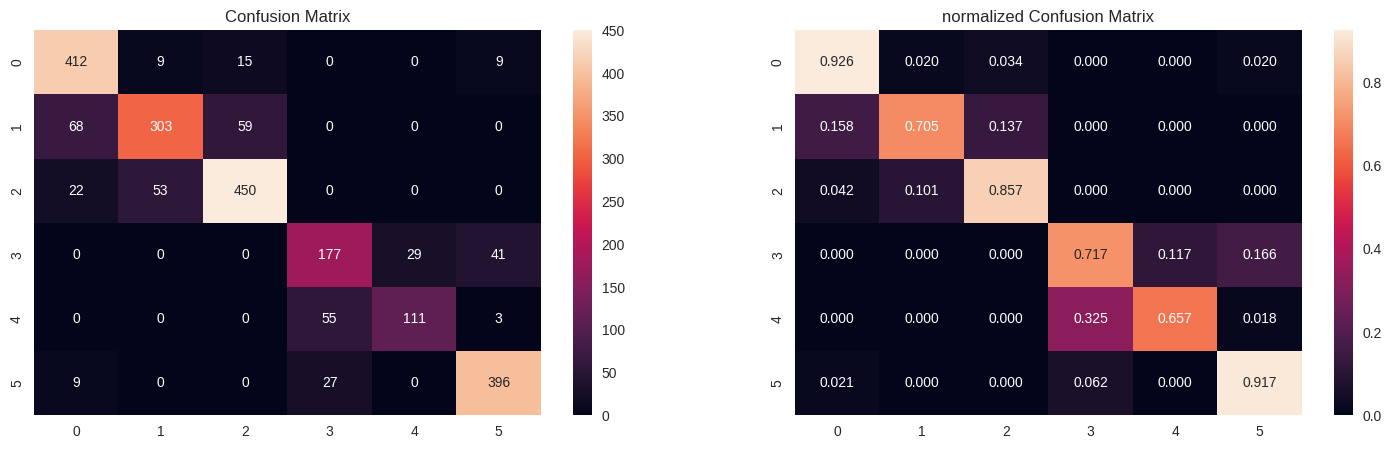

In [30]:
_, _, correct_labels, predicted_labels = eval_model_conf(model0, val_loader, criterion, device)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# calculate absolute confusion matrix
confusion_matr = confusion_matrix(correct_labels, predicted_labels)#, labels=[0,1,2,3,4,5,6,7,8,9])
df_confusion = pd.DataFrame(confusion_matr, range(confusion_matr.shape[0]), range(confusion_matr.shape[0]))
# calculate confusion matric normalized in rows
confusion_matr_norm = confusion_matrix(correct_labels, predicted_labels, normalize = 'true') #, labels=[0,1,2,3,4,5,6,7,8,9]
df_confusion_norm = pd.DataFrame(confusion_matr_norm, range(confusion_matr_norm.shape[0]), range(confusion_matr_norm.shape[0]))

print('0:boxing, 1:handclapping, 2:handwaving, 3:jogging, 4:running, 5:walking')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("True Label")
ax[0].set_title("Confusion Matrix")
sn.heatmap(df_confusion, annot=True, annot_kws={"size": 10}, fmt="d", ax=ax[0]) 


ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("True Label")
ax[1].set_title("normalized Confusion Matrix")
sn.heatmap(df_confusion_norm, annot=True, annot_kws={"size": 10}, fmt=".3f", ax=ax[1]) 

acc = 0
for i in range(confusion_matr.shape[0]):
  acc = acc + confusion_matr[i,i]
acc = acc/confusion_matr.sum()*100
print(f"Test accuracy: {round(acc,2)}%")

The confusion matrix looks also similar to the confusion matrix of the convLSTM. But jogging is confused less with walking and clapping and waving is also confused less. Running and jogging is confused slightly more.